<a href="https://colab.research.google.com/github/jui-pung/VehicleRecognition_YOLO/blob/main/YOLOv3_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sat May 22 09:18:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15050, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15050 (delta 16), reused 34 (delta 14), pack-reused 15002
Receiving objects: 100% (15050/15050), 13.45 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (10214/10214), done.


In [ ]:
! sed -i "s/GPU=0/GPU=1/g" /content/darknet/Makefile
! sed -i "s/CUDNN=0/CUDNN=1/g" /content/darknet/Makefile
! sed -i "s/OPENCV=0/OPENCV=1/g" /content/darknet/Makefile

In [ ]:
! head darknet/Makefile

GPU=1
CUDNN=1
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0



In [ ]:
! cd darknet; make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

**雲端硬碟掛載到content下**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp "/content/drive/MyDrive/aidataset/car_dataset.zip" /content/

In [ ]:
! unzip /content/car_dataset.zip > data_unzip.log

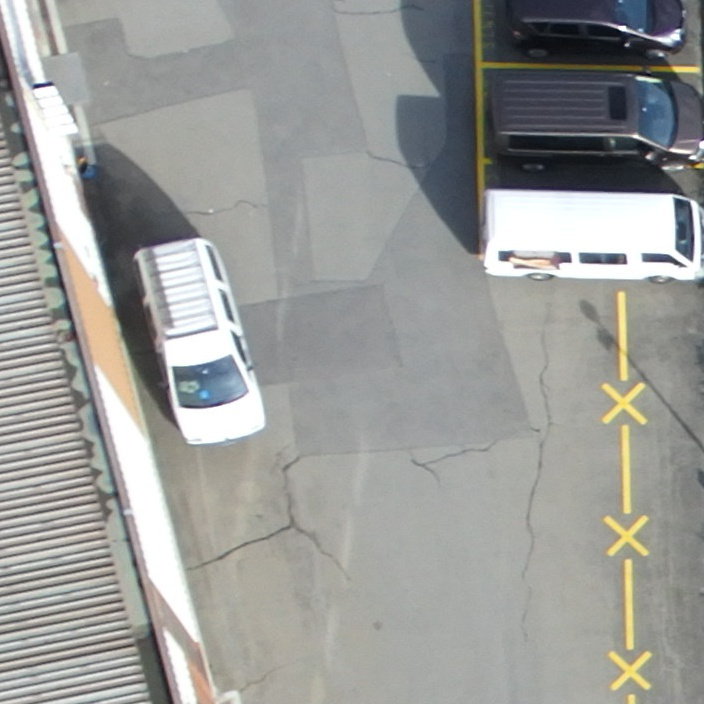

In [ ]:
from PIL import Image
img = Image.open('/content/car_dataset_test/images/1.jpg')
img

In [ ]:
! cat /content/car_dataset/labels/1.xml

<annotation>
	<folder>images</folder>
	<filename>1.jpg</filename>
	<path>C:\Users\jui pung\Desktop\car_dataset\images\1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>704</width>
		<height>704</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>131</xmin>
			<ymin>235</ymin>
			<xmax>271</xmax>
			<ymax>449</ymax>
		</bndbox>
	</object>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>479</xmin>
			<ymin>184</ymin>
			<xmax>704</xmax>
			<ymax>284</ymax>
		</bndbox>
	</object>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>484</xmin>
			<ymin>68</ymin>
			<xmax>704</xmax>
			<ymax>174</ymax>
		</bndbox>
	</object>
</annotation>


In [ ]:
! rm -rf /content/yolo
! mkdir /content/yolo

In [ ]:
from bs4 import BeautifulSoup
import os
import shutil

status_dic = {'car': 0}
def getYoloFormat(filename,label_path, img_path, yolo_path, newname):
    with open(label_path+ filename, 'r') as f:
        soup = BeautifulSoup(f.read(), 'xml')
        imgname = soup.select_one('filename').text
        image_w = int(soup.select_one('width').text)
        image_h = int(soup.select_one('height').text)
        ary = []
        for obj in soup.select('object'):
            xmin = int(obj.select_one('xmin').text)
            xmax = int(obj.select_one('xmax').text)
            ymin = int(obj.select_one('ymin').text)
            ymax = int(obj.select_one('ymax').text)
            objclass = status_dic.get(obj.select_one('name').text)

            x = (xmin + (xmax-xmin)/2) * 1.0 / image_w
            y = (ymin + (ymax-ymin)/2) * 1.0 / image_h
            w = (xmax-xmin) * 1.0 / image_w
            h = (ymax-ymin) * 1.0 / image_h
            ary.append(' '.join([str(objclass), str(x),str(y),str(w),str(h)]))
        if os.path.exists(img_path + imgname):
            shutil.copyfile(img_path + imgname, yolo_path + newname + '.jpg')
            with open(yolo_path + newname + '.txt', 'w') as f:
                f.write('\n'.join(ary))

In [ ]:
import os
labelpath = '/content/car_dataset_test/labels/'
imgpath   = '/content/car_dataset_test/images/'
yolopath  = '/content/yolo/'
ary = []
for idx, f in enumerate(os.listdir(labelpath)):
    try:
        getYoloFormat(f, labelpath,imgpath, yolopath, str(idx))
    except Exception as e:
        print(e)

In [ ]:
! cat /content/yolo/103.txt

0 0.6292613636363636 0.22798295454545456 0.29261363636363635 0.203125
0 0.7038352272727273 0.3643465909090909 0.2571022727272727 0.18892045454545456
0 0.7982954545454546 0.5 0.2784090909090909 0.19318181818181818
0 0.8870738636363636 0.8274147727272727 0.22585227272727273 0.18323863636363635

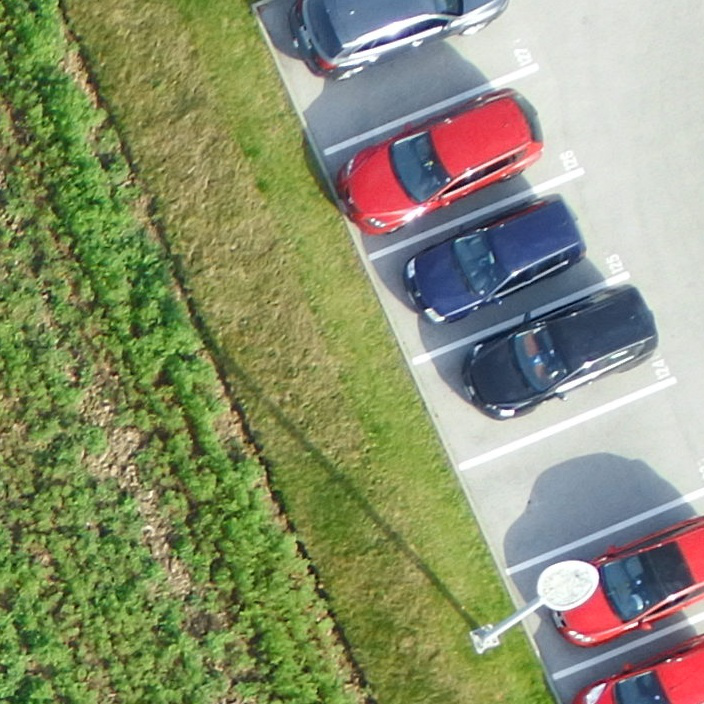

In [ ]:
from PIL import Image
Image.open('/content/yolo/103.jpg')

# **準備訓練與測試資料集**

In [ ]:
! rm -rf /content/cfg_mask
! mkdir /content/cfg_mask

In [ ]:
import os
datasets = ['/content/yolo/'+ f for f in os.listdir('/content/yolo/') if not f.endswith('.txt')]
len(datasets) * 0.8

292.8

In [ ]:
with open('/content/cfg_mask/train.txt', 'w') as f:
    f.write('\n'.join(datasets[0:292]))

In [ ]:
with open('/content/cfg_mask/test.txt', 'w') as f:
    f.write('\n'.join(datasets[292:]))

# **複製參數檔案**

In [ ]:
! cp "/content/drive/My Drive/aidataset/cfg_mask/obj.data" cfg_mask/
! cp "/content/drive/My Drive/aidataset/cfg_mask/obj.names" cfg_mask/

In [ ]:
! head /content/cfg_mask/obj.data

classes= 1
train  = /content/drive/My Drive/aidataset/cfg_mask/train.txt
valid  = /content/drive/My Drive/aidataset/cfg_mask/test.txt
names  = /content/drive/My Drive/aidataset/cfg_mask/obj.names
backup = /content/drive/My Drive/aidataset/cfg_mask/

In [ ]:
! head /content/cfg_mask/obj.names

car

# **建立權重資料夾**

In [ ]:
! mkdir /content/cfg_mask/weights

# **YOLO v3 架構**

In [ ]:
%%html
<img src='https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png' width="800px" />

In [ ]:
%%html
<img src='https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png' width="500px" />

# **修改 yolov3-tiny.cfg**
*   YOLOV3 偵測的濾鏡(filter) 大小為 (C+5)*B.
*   B 是每個Feature Map 可以偵測的Bounding Box 數量
*   5 是Bounding Box 的x,y,w,h 以及 Confidence
*   C 是類別數量
*   filters=(classes + 5)*3 # 24
*   classes=3

In [ ]:
! cp /content/darknet/cfg/yolov3-tiny.cfg /content/cfg_mask/

In [ ]:
! sed -n -e 3p -e 4p -e 127p -e 135p -e 171p -e 177p /content/cfg_mask/yolov3-tiny.cfg

batch=1
subdivisions=1
filters=255
classes=80
filters=255
classes=80


In [ ]:
! sed -i '3s/1/64/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '4s/1/64/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '127s/255/18/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '135s/80/1/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '171s/255/18/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '177s/80/1/' /content/cfg_mask/yolov3-tiny.cfg

In [ ]:
! sed -n -e 3p -e 4p -e 127p -e 135p -e 171p -e 177p /content/cfg_mask/yolov3-tiny.cfg

batch=64
subdivisions=64
filters=18
classes=1
filters=18
classes=1


In [ ]:
! cp "/content/drive/My Drive/aidataset/darknet53.conv.74" /content/cfg_mask/

In [ ]:
! cp "/content/drive/My Drive/aidataset/darknet53.conv.74" /content/cfg_mask/

# **訓練模型**

In [ ]:
! darknet/darknet detector train -dont_show "/content/cfg_mask/obj.data" /content/cfg_mask/yolov3-tiny.cfg "/content/drive/MyDrive/aidataset/cfg_mask/yolov3-tiny_last_17000.weights" "/content/drive/My Drive/aidataset/cfg_mask/yolov3-tiny_last.weights" -map

串流輸出內容已截斷至最後 5000 行。
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.848232), count: 4, class_loss = 0.001387, iou_loss = 0.239128, total_loss = 0.240515 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.006919, iou_loss = 0.000000, total_loss = 0.006919 
 total_bbox = 337656, rewritten_bbox = 0.210273 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.921813), count: 2, class_loss = 0.000030, iou_loss = 0.085459, total_loss = 0.085489 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.000000), count: 1, class_loss = 0.000004, iou_loss = 0.000000, total_loss = 0.000004 
 total_bbox = 337658, rewritten_bbox = 0.210272 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.916160), count: 2, class_loss = 0.000016, iou_loss = 0.036036, total_loss = 0.036052 
v3 (mse loss, Normalizer: (iou: 0.75,